Data Quality Pipeline (Autoencoder)

This notebook walks through step-by-step EDA, preprocessing, autoencoder training and data-quality risk scoring for the JM1 dataset.

In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [132]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [133]:
FEATURE_COLS = [
    "loc",
    "v(g)",
    "ev(g)",
    "iv(g)",
    "n",
    "v",
    "l",
    "d",
    "i",
    "e",
    "b",
    "t",
    "lOCode",
    "lOComment",
    "lOBlank",
    "locCodeAndComment",
    "uniq_Op",
    "uniq_Opnd",
    "total_Op",
    "total_Opnd",
    "branchCount"
]
DEFAULT_TARGET = "defects"
JM1_METRIC_NAMES = {
    # ----- Basic Size Metrics -----
    "loc": "Lines of Code (LOC)",
    "locCodeAndComment": "Lines of Code + Comments",

    # ----- Cyclomatic Complexity -----
    "v(g)": "Cyclomatic Complexity",
    "ev(g)": "Essential Cyclomatic Complexity",
    "iv(g)": "Design Cyclomatic Complexity",

    # ----- Halstead Metrics -----
    "n": "Halstead Total Operands",
    "v": "Halstead Volume",
    "l": "Halstead Program Length Ratio",
    "d": "Halstead Difficulty",
    "i": "Halstead Intelligence / Content",
    "e": "Halstead Effort",
    "b": "Halstead Estimated Bugs",
    "t": "Halstead Time to Implement",

    # ----- Halstead Operators/Operands -----
    "uniq_Op": "Unique Operators",
    "uniq_Opnd": "Unique Operands",
    "total_Op": "Total Operators",
    "total_Opnd": "Total Operands",

    # ----- Structural Metrics -----
    "branchCount": "Number of Branches in Code",

    # ----- I/O Related Metrics (if present) -----
    "lOCode": "Input/Output Code Count",
    "lOComment": "Input/Output Comment Count",
    "lOBlank": "Input/Output Blank Lines",

    # ----- Target -----
    "defects": "Defect Label (0 = Clean, 1 = Defective)"
}


In [134]:
#Hyper-parameters
batch_size = 16
epochs = 40
learning_rate = 0.001
latent_dim = 8 #specifies the size of the compressed feature vector (bottleneck) in an autoencoder
early_stopping_patience = 6 #number of epochs with no improvement after which training will be stopped

In [135]:
OUT_DIR = '../results'
os.makedirs(OUT_DIR, exist_ok=True)

In [136]:
#Loading the dataset
df = pd.read_csv("../data/JM1_dataset.csv")


In [137]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True


In [138]:
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13199,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,...,13,0,2,0,10.0,15.0,30.0,22.0,7.0,False
13200,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,...,5,0,2,0,12.0,8.0,19.0,11.0,3.0,False
13201,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,...,29,1,10,0,18.0,15.0,59.0,44.0,7.0,False
13202,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,...,6,0,2,0,9.0,8.0,21.0,15.0,1.0,False


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13204 entries, 0 to 13203
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                13204 non-null  float64
 1   v(g)               13204 non-null  float64
 2   ev(g)              13204 non-null  float64
 3   iv(g)              13204 non-null  float64
 4   n                  13204 non-null  float64
 5   v                  13204 non-null  float64
 6   l                  13204 non-null  float64
 7   d                  13204 non-null  float64
 8   i                  13204 non-null  float64
 9   e                  13204 non-null  float64
 10  b                  13204 non-null  float64
 11  t                  13204 non-null  float64
 12  lOCode             13204 non-null  int64  
 13  lOComment          13204 non-null  int64  
 14  lOBlank            13204 non-null  int64  
 15  locCodeAndComment  13204 non-null  int64  
 16  uniq_Op            132

In [140]:
print("\n--- Missing Values Count ---")
print(df.isnull().sum())


--- Missing Values Count ---
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


In [141]:
# Sanitize target column to ensure 0/1 ints

def sanitize_target_col(df, col='defects'):
    if col not in df.columns:
        raise ValueError(f"Target column '{col}' not found in DataFrame")
    s = df[col]
    # Convert booleans
    if s.dtype == bool:
        return df.assign(**{col: s.astype(int)})
    # Try numeric conversion
    try:
        num = pd.to_numeric(s)
        unique = set(num.dropna().unique())
        if unique.issubset({0,1}):
            return df.assign(**{col: num.astype(int)})
    except Exception:
        pass
    # Map common string representations
    def map_bool(x):
        if pd.isna(x):
            return np.nan
        st = str(x).strip().lower()
        if st in {'true','t','1','yes','y'}:
            return 1
        if st in {'false','f','0','no','n'}:
            return 0
        try:
            return int(float(st))
        except Exception:
            return np.nan
    return df.assign(**{col: s.apply(map_bool)})

df = sanitize_target_col(df, DEFAULT_TARGET)
df[DEFAULT_TARGET].value_counts(dropna=False)


defects
0    11101
1     2103
Name: count, dtype: int64

In [142]:
total_rows = len(df)

defect_counts = df[DEFAULT_TARGET].value_counts()
    
count_clean = defect_counts.get(0, 0)
count_defective = defect_counts.get(1, 0)

perc_clean = (count_clean / total_rows) * 100 if total_rows > 0 else 0
perc_defective = (count_defective / total_rows) * 100 if total_rows > 0 else 0

print("--- Defect Class Distribution Summary ---")
print(f"Total Modules (Rows): {total_rows}")

print(f"Clean Modules (Defects = 0): {count_clean:,} ({perc_clean:.2f}%)")
print(f"Defective Modules (Defects = 1): {count_defective:,} ({perc_defective:.2f}%)")


--- Defect Class Distribution Summary ---
Total Modules (Rows): 13204
Clean Modules (Defects = 0): 11,101 (84.07%)
Defective Modules (Defects = 1): 2,103 (15.93%)


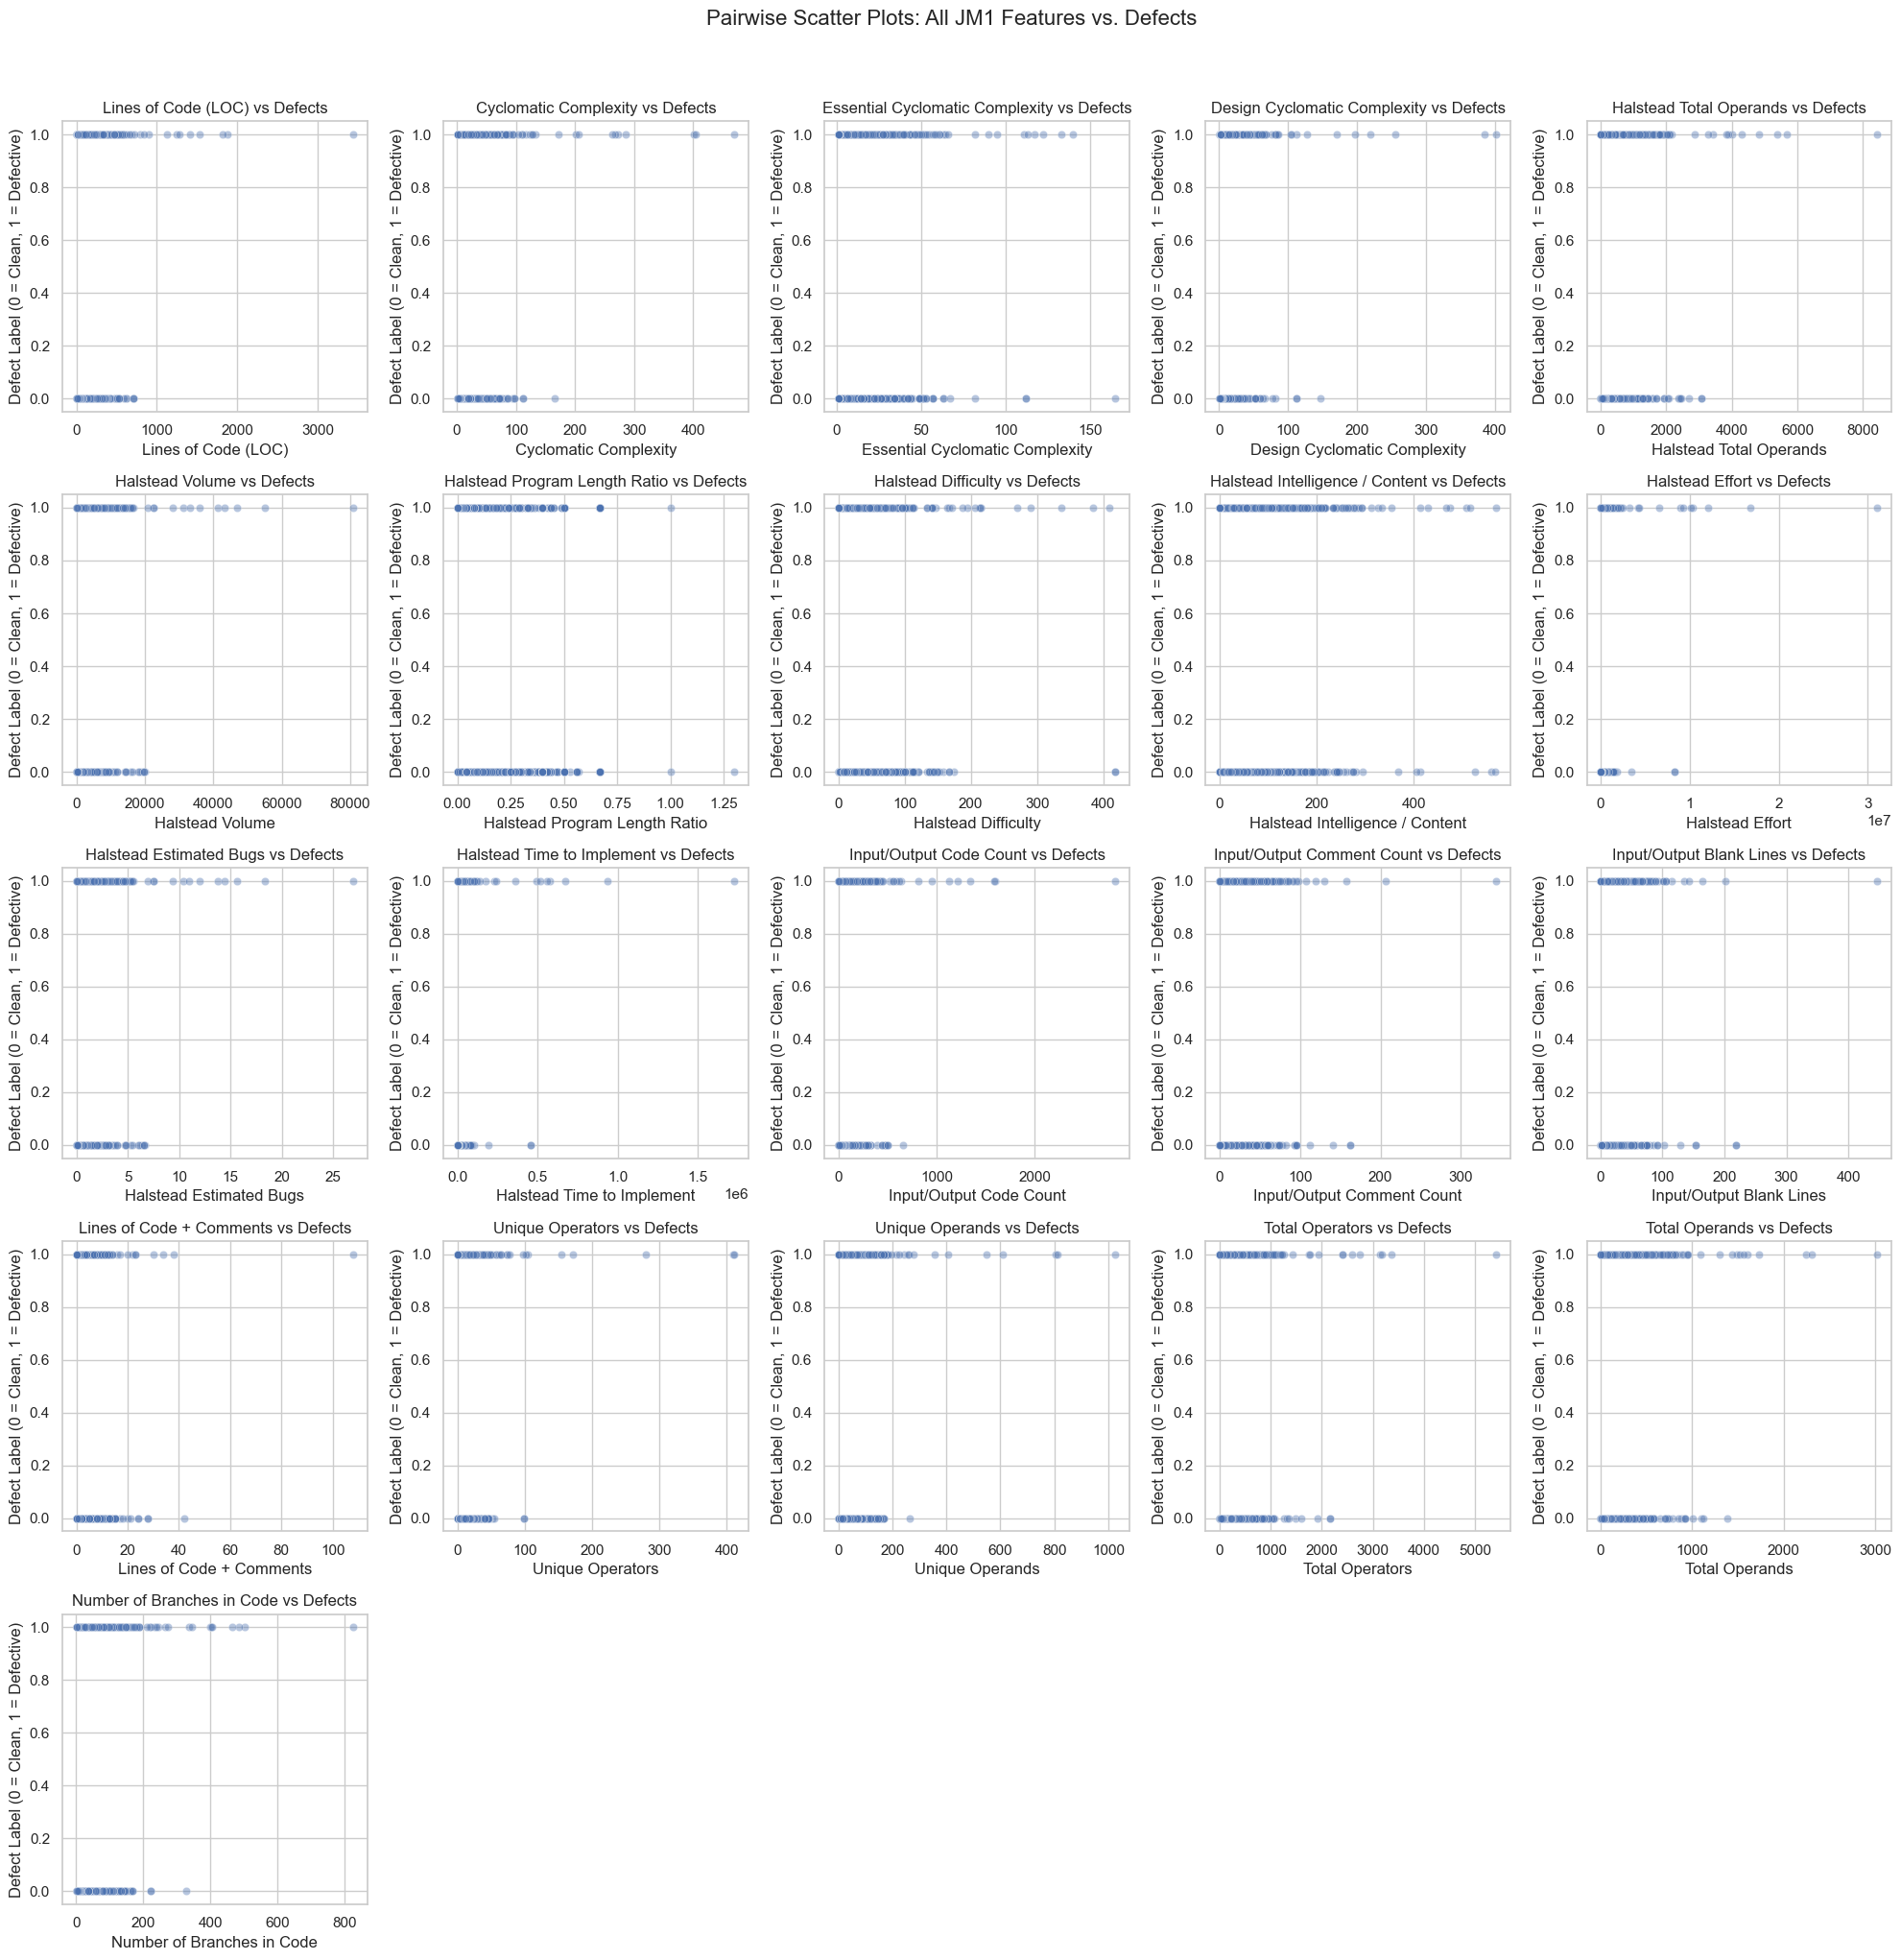

In [143]:
sns.set(style="whitegrid")

# Define the list of all features to plot

# Function to get the full metric name for labeling
def label(col):
    return JM1_METRIC_NAMES.get(col, col)

# --- Create the consolidated scatter plot figure ---

# Calculate number of rows and columns for the subplot grid
num_features = len(FEATURE_COLS)
# We aim for roughly a square grid, e.g., 5x5 for 21 features
ncols = 5
nrows = (num_features + ncols - 1) // ncols

plt.figure(figsize=(20, 4 * nrows)) # Adjust figure size based on number of rows

# Loop through each feature and create a subplot
for i, col in enumerate(FEATURE_COLS, 1):
    plt.subplot(nrows, ncols, i)

    # Use scatterplot for the binary target variable
    sns.scatterplot(data=df, x=col, y="defects", alpha=0.4)

    # Set labels and title using the descriptive names
    plt.xlabel(label(col))
    plt.ylabel(label("defects"))
    plt.title(f"{label(col)} vs Defects")

plt.suptitle("Pairwise Scatter Plots: All JM1 Features vs. Defects", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

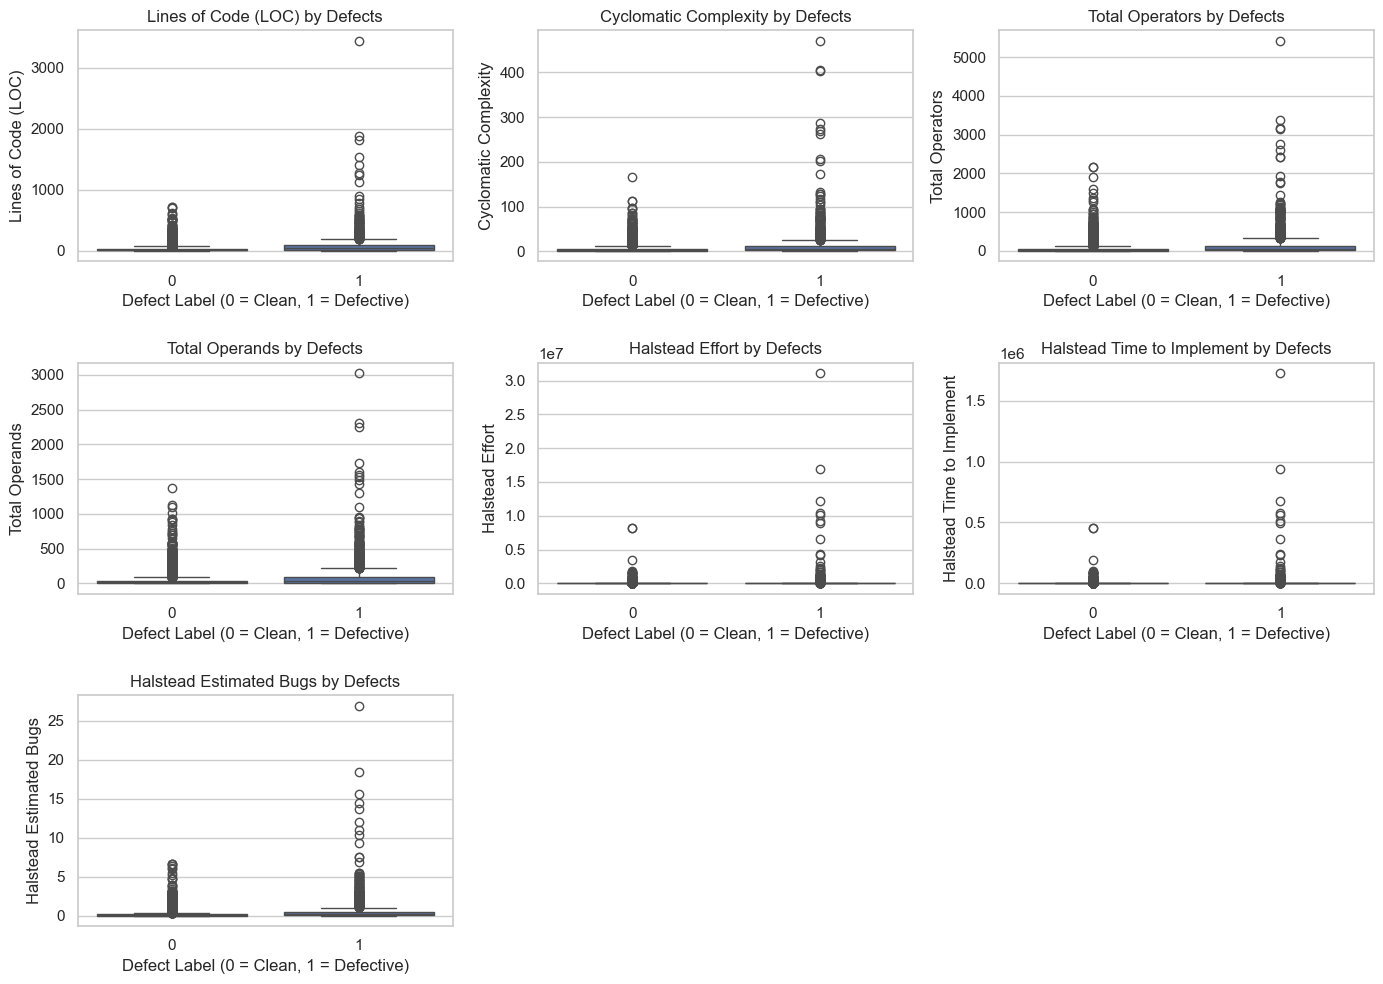

In [144]:
# Boxplots for defective vs non-defective

boxplot_cols = [
    "loc",
    "v(g)",
    "total_Op",
    "total_Opnd",
    "e",   # Halstead effort
    "t",   # Halstead time
    "b"    # Halstead bugs
]

plt.figure(figsize=(14,10))

for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x="defects", y=col)
    plt.xlabel(label("defects"))
    plt.ylabel(label(col))
    plt.title(f"{label(col)} by Defects")

plt.tight_layout()
plt.show()


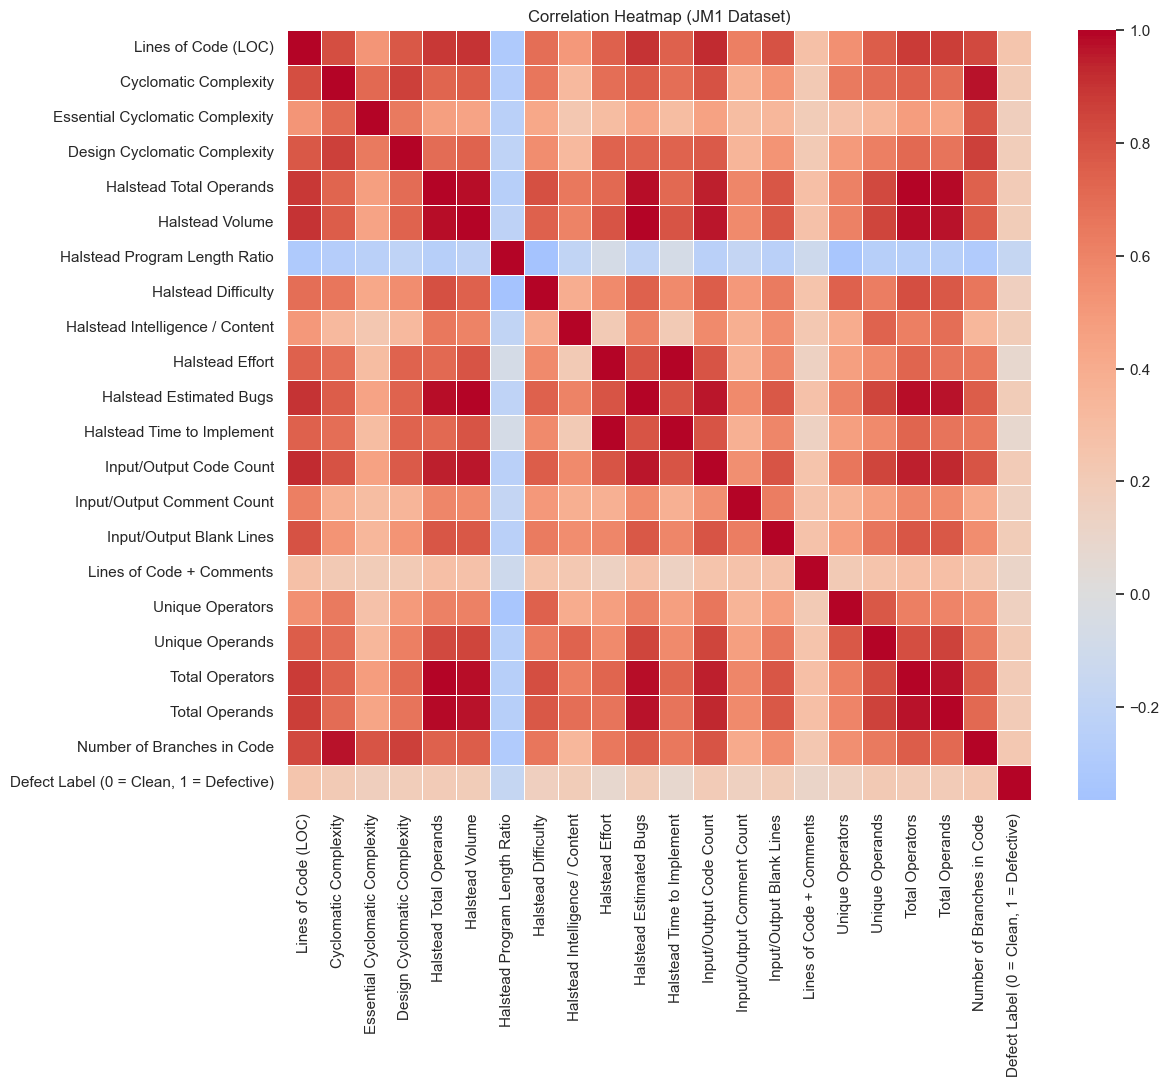

In [145]:
# Correlation Heatmap for JM1 Metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12,10))

features = [c for c in FEATURE_COLS if c in df.columns]

corr = df[features + ["defects"]].corr()

sns.heatmap(
    corr,
    annot=False,       # set to True if you want numbers printed
    cmap="coolwarm",
    linewidths=0.5,
    center=0,
    xticklabels=[JM1_METRIC_NAMES.get(col, col) for col in corr.columns],
    yticklabels=[JM1_METRIC_NAMES.get(col, col) for col in corr.index]
)

plt.title("Correlation Heatmap (JM1 Dataset)")
plt.show()


In [146]:
# ----- Select Features & Scale -----

# Make sure we only use features that actually exist in the dataframe
usable_features = [c for c in FEATURE_COLS if c in df.columns]
print("Using feature columns:", usable_features)

X = df[usable_features].copy()
y = df[DEFAULT_TARGET].copy()    # not used in training, only for analysis

# # Fill missing values
# X = X.fillna(X.median())

# Standard scaling for AE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)


Using feature columns: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
Scaled shape: (13204, 21)


In [147]:
# ----- Train AE on only non-defective modules -----
clean_mask = (y == 0)
X_clean = X_scaled[clean_mask]

print("Clean samples:", X_clean.shape[0])

# Train/validation split
X_train, X_val = train_test_split(
    X_clean, test_size=0.2, random_state=RANDOM_SEED
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Clean samples: 11101
Train shape: (8880, 21)
Validation shape: (2221, 21)


In [148]:
# ----- Autoencoder Model -----

input_dim = X_train.shape[1]

inputs = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation="relu")(inputs)
encoded = layers.Dense(16, activation="relu")(encoded)
encoded = layers.Dense(latent_dim, activation="relu")(encoded)

decoded = layers.Dense(16, activation="relu")(encoded)
decoded = layers.Dense(32, activation="relu")(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = tf.keras.Model(inputs, decoded)

autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="mse"
)

autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,749 (10.74 KB)

 Trainable params: 2,749 (10.74 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
# ----- Training with Early Stopping -----

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)


Epoch 1/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1647 - val_loss: 0.0959
Epoch 2/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0769 - val_loss: 0.0711
Epoch 3/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 0.0525 - val_loss: 0.0508
Epoch 4/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0388 - val_loss: 0.0440
Epoch 5/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - loss: 0.0340 - val_loss: 0.0390
Epoch 6/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0306 - val_loss: 0.0360
Epoch 7/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0285 - val_loss: 0.0314
Epoch 8/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0265 - val_loss: 0.0285
Epoch 9/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0249 - val_loss: 0.0279
Epoch 10/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0239 - val_loss: 0.0271
Epoch 11/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0230 - val_loss: 0.0264
Epoch 12/40
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

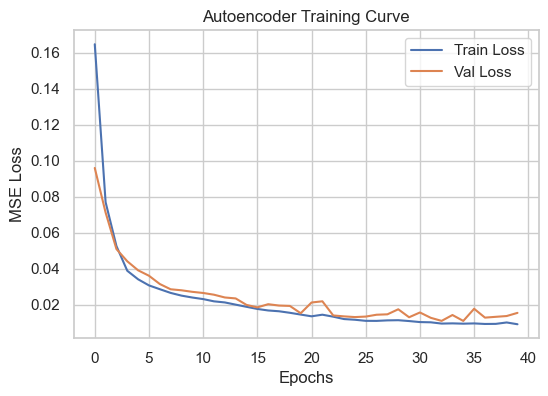

In [150]:
# ----- Plot Training/Validation Loss -----

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Curve")
plt.legend()
plt.show()


In [151]:
# ----- Compute Reconstruction Errors -----

X_recon = autoencoder.predict(X_scaled)
reconstruction_mse = np.mean(np.square(X_scaled - X_recon), axis=1)

df["reconstruction_mse"] = reconstruction_mse

print("Reconstruction error stats:")
df["reconstruction_mse"].describe()


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
Reconstruction error stats:


count    13204.000000
mean         0.061666
std          2.662647
min          0.000219
25%          0.001375
50%          0.002347
75%          0.006807
max        256.567777
Name: reconstruction_mse, dtype: float64

In [152]:
# ----- Normalize MSE into a 0–1 risk score -----

# Use only clean modules to estimate "normal" error distribution
clean_mse = df.loc[y == 0, "reconstruction_mse"]

p95 = np.percentile(clean_mse, 95)
print("95th percentile (clean):", p95)

def normalize_mse(e):
    return min(1.0, max(0.0, e / (p95 + 1e-12)))

df["data_risk_score"] = df["reconstruction_mse"].apply(normalize_mse)

df[["reconstruction_mse", "data_risk_score"]].head()


95th percentile (clean): 0.03391904552648866


,reconstruction_mse,data_risk_score
0,0.349499,1.000000
1,0.185429,1.000000
2,0.006257,0.184473
3,0.110521,1.000000
4,0.002104,0.062025


In [153]:
# ----- Save Output -----

output_path = os.path.join(OUT_DIR, "data_risk_scores.csv")
df.to_csv(output_path, index=False)

print("Saved:", output_path)

# show highest-risk modules
df.sort_values("data_risk_score", ascending=False).head(10)


Saved: ../results\data_risk_scores.csv


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects,reconstruction_mse,data_risk_score
12845,100.0,4.0,1.0,4.0,600.0,4233.17,0.06,17.54,241.31,74259.84,...,1,0,15.0,118.0,324.0,276.0,7.0,0,0.059820,1.0
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,28,2,17.0,135.0,329.0,271.0,5.0,1,0.110521,1.0
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1.0,1.0,1.0,1.0,1.0,1,0.185429,1.0
57,162.0,27.0,23.0,26.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,53.0,1,0.034521,1.0
62,179.0,36.0,27.0,35.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,71.0,1,0.042303,1.0
63,171.0,16.0,1.0,16.0,644.0,4230.99,0.03,34.25,123.53,144911.31,...,24,22,19.0,76.0,370.0,274.0,31.0,1,0.087624,1.0
48,466.0,110.0,95.0,85.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,219.0,1,0.293632,1.0
49,110.0,27.0,14.0,9.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,53.0,1,0.042582,1.0
6164,123.0,27.0,15.0,7.0,643.0,4334.76,0.02,50.68,85.53,219701.17,...,7,1,28.0,79.0,357.0,286.0,53.0,0,0.058417,1.0
6152,143.0,16.0,7.0,14.0,492.0,3045.39,0.03,34.33,88.72,104538.99,...,18,8,21.0,52.0,322.0,170.0,31.0,0,0.041629,1.0


In [154]:
# Evaluation summary: ROC-AUC, PR-AUC, best F1 threshold, Precision@K
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import numpy as np

assert 'defects' in df.columns and 'data_risk_score' in df.columns

y_true = df['defects'].astype(int).values
y_score = df['data_risk_score'].values

roc = roc_auc_score(y_true, y_score)
prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(rec, prec)

best_thr = 0.0
best_f1 = 0.0
for thr in np.linspace(0,1,101):
    preds = (y_score >= thr).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1; best_thr = thr

def precision_at_k(y_true, scores, k):
    idx = np.argsort(scores)[::-1][:k]
    return y_true[idx].sum() / float(k)

p10 = precision_at_k(y_true, y_score, 10) if len(y_score) >= 10 else None
p20 = precision_at_k(y_true, y_score, 20) if len(y_score) >= 20 else None
p50 = precision_at_k(y_true, y_score, 50) if len(y_score) >= 50 else None

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print(f"Best F1: {best_f1:.4f} at threshold {best_thr:.2f}")
print(f"Precision@10: {p10 if p10 is not None else 'n/a'}")
print(f"Precision@20: {p20 if p20 is not None else 'n/a'}")
print(f"Precision@50: {p50 if p50 is not None else 'n/a'}")


ROC-AUC: 0.6733
PR-AUC:  0.3482
Best F1: 0.3721 at threshold 0.16
Precision@10: 0.3
Precision@20: 0.15
Precision@50: 0.26


In [155]:
# Show top 10 high-risk modules
display(df.sort_values('data_risk_score', ascending=False).head(10)[['data_risk_score','reconstruction_mse', 'defects']])

,data_risk_score,reconstruction_mse,defects
12845,1.0,0.059820,0
3,1.0,0.110521,1
1,1.0,0.185429,1
57,1.0,0.034521,1
62,1.0,0.042303,1
63,1.0,0.087624,1
48,1.0,0.293632,1
49,1.0,0.042582,1
6164,1.0,0.058417,0
6152,1.0,0.041629,0


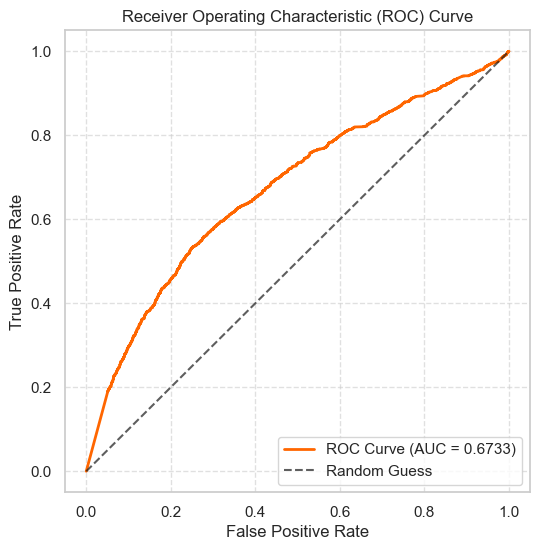

In [156]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, confusion_matrix
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure(figsize=(6, 6))
    
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc:.4f})', color='#ff6600', linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # [Image of a Receiver Operating Characteristic (ROC) curve]

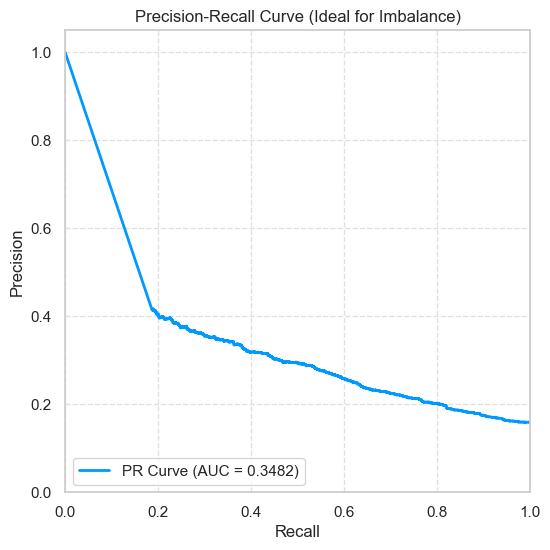

In [157]:
plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f'PR Curve (AUC = {pr_auc:.4f})', color='#0099ff', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Ideal for Imbalance)')
plt.legend(loc='lower left')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # [Image of a Precision-Recall Curve]

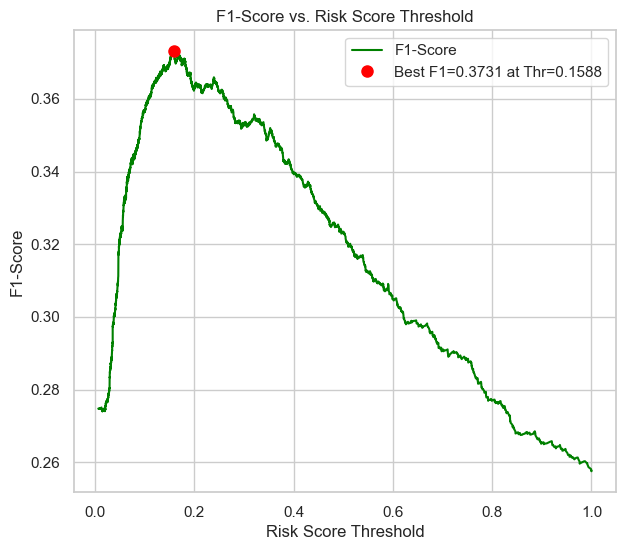

In [158]:
precision_points, recall_points, thresholds = precision_recall_curve(y_true, y_score)
    
# F1 is calculated from P and R, which are calculated at N-1 threshold points
f1_scores = 2 * (precision_points * recall_points) / (precision_points + recall_points + 1e-12)
    
# Since thresholds array is 1 element shorter than P/R arrays, we handle it
# We use the F1 index (excluding the last point which has no threshold)
max_f1_idx = np.argmax(f1_scores[:-1])
    
# Start plot
plt.figure(figsize=(7, 6))
    
# Plot F1 Score
plt.plot(thresholds, f1_scores[:-1], label='F1-Score', color='green')
    
# Highlight the maximum F1 point
plt.plot(thresholds[max_f1_idx], f1_scores[max_f1_idx], 'o', color='red', markersize=8, 
             label=f'Best F1={f1_scores[max_f1_idx]:.4f} at Thr={thresholds[max_f1_idx]:.4f}')
    
plt.xlabel('Risk Score Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Risk Score Threshold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [159]:
# --- Isolation Forest Implementation ---

from sklearn.ensemble import IsolationForest

print("\n--- Training Isolation Forest ---")

# The Isolation Forest model is typically trained on clean data to learn 'normality'.
# We use the same scaled clean data as the Autoencoder.
X_if_train = X_clean

# Initialize Isolation Forest
# contamination is set to 'auto' or can be specified as a float (e.g., 0.05 for 5% expected anomalies).
# 'auto' lets the model decide, which is often fine for a first pass.
# We set a fixed random state for reproducibility.
if_model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    random_state=RANDOM_SEED,
    n_jobs=-1 # Use all available cores
)

# Train the model
if_model.fit(X_if_train)

# --- Compute Anomaly Scores ---

# Note: Isolation Forest returns a 'decision_function' where *lower* values indicate *higher* anomaly scores.
# The 'anomaly_score' we want is the *opposite* of the decision function output.
# We apply the model to the full scaled dataset X_scaled (clean + defective).
decision_scores = if_model.decision_function(X_scaled)

# Convert decision scores to an intuitive anomaly score (higher score = higher risk)
# We can use a simple negation for this, or scale it. Negation is the simplest interpretation.
df["if_anomaly_score"] = -decision_scores

print("Isolation Forest Anomaly Score stats:")
df["if_anomaly_score"].describe()

# --- Evaluate Isolation Forest Performance ---

# The IF score is already an anomaly measure, so we can use it directly for evaluation.
y_if_score = df["if_anomaly_score"].values

if_roc = roc_auc_score(y_true, y_if_score)
if_prec, if_rec, _ = precision_recall_curve(y_true, y_if_score)
if_pr_auc = auc(if_rec, if_prec)

# Find best F1 threshold for IF
if_best_f1 = 0.0
if_best_thr = 0.0
for thr in np.linspace(min(y_if_score), max(y_if_score), 101):
    preds = (y_if_score >= thr).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > if_best_f1:
        if_best_f1 = f1; if_best_thr = thr

if_p10 = precision_at_k(y_true, y_if_score, 10) if len(y_if_score) >= 10 else None
if_p20 = precision_at_k(y_true, y_if_score, 20) if len(y_if_score) >= 20 else None
if_p50 = precision_at_k(y_true, y_if_score, 50) if len(y_if_score) >= 50 else None

print("\n--- Isolation Forest Evaluation Summary ---")
print(f"ROC-AUC: {if_roc:.4f}")
print(f"PR-AUC:  {if_pr_auc:.4f}")
print(f"Best F1: {if_best_f1:.4f} at threshold {if_best_thr:.4f}")
print(f"Precision@10: {if_p10 if if_p10 is not None else 'n/a'}")
print(f"Precision@20: {if_p20 if if_p20 is not None else 'n/a'}")
print(f"Precision@50: {if_p50 if if_p50 is not None else 'n/a'}")

# --- Comparison with Autoencoder ---
print("\n--- Model Comparison ---")
print(f"| Metric | Autoencoder | Isolation Forest |")
print(f"|---|---|---|")
print(f"| ROC-AUC | {roc:.4f} | {if_roc:.4f} |")
print(f"| PR-AUC | {pr_auc:.4f} | {if_pr_auc:.4f} |")
print(f"| Best F1 | {best_f1:.4f} | {if_best_f1:.4f} |")

# Show top 10 high-risk modules by IF
print("\nTop 10 High-Risk Modules (Isolation Forest)")
display(df.sort_values('if_anomaly_score', ascending=False).head(10)[['if_anomaly_score', 'reconstruction_mse', 'defects']])


--- Training Isolation Forest ---
Isolation Forest Anomaly Score stats:

--- Isolation Forest Evaluation Summary ---
ROC-AUC: 0.6887
PR-AUC:  0.3311
Best F1: 0.3922 at threshold -0.0883
Precision@10: 1.0
Precision@20: 0.8
Precision@50: 0.7

--- Model Comparison ---
| Metric | Autoencoder | Isolation Forest |
|---|---|---|
| ROC-AUC | 0.6733 | 0.6887 |
| PR-AUC | 0.3482 | 0.3311 |
| Best F1 | 0.3721 | 0.3922 |

Top 10 High-Risk Modules (Isolation Forest)


,if_anomaly_score,reconstruction_mse,defects
2103,0.347246,256.567777,1
2099,0.344957,19.873710,1
2095,0.344385,51.638168,1
2096,0.343243,17.079749,1
2100,0.341533,46.090723,1
2098,0.340964,15.282525,1
2090,0.339827,1.971492,1
2057,0.335294,6.032046,1
2097,0.333600,1.859577,1
377,0.332473,0.291461,1
